# Dynamic Connection Layer

The DynamicConnectionLayer is designed to update the atomic features and the molecular internal connections/interactions within a molecule. This layer takes two tensors as input: X (atoms, features) representing the types of atoms, and A (atoms, atoms) representing the molecular internal connections.

In this design, techniques such as multi-head attention and random noise are primarily used. The overall data flow of the layer follows the pattern of a graph convolutional network, with $$X' = (A'w_a * X)N.$$ Here, $w_a$ is a weight tensor used to adjust the original features, and $A'$ is the updated molecular internal connection tensor. $N$ is the normalization parameter calculated as the degree of $A'$ divided by the number of heads.

1. The internal connection tensor $A$ is updated within the layer in three steps. First, an attention matrix $X_A$, (num_heads, atoms, atoms), is computed based on the atomic feature vectors. The formula for $X_A$ is: $$X_A = a(w_1 * X * (w_2 * X)^T)$$ where $w_1$ and $w_2$ are two separate weight matrices for adjusting the original atomic features X$$, and $a$ is the chosen activation function. The use of multi-head attention aims to mimic the description of atomic interactions in molecular orbital theory, where interactions are a composite of various independent subspaces. The computed attention matrix $X_A$ can be interpreted as the standard action size between atom pairs under the current atomic features.
2. The second step in updating the molecular connections involves calculating the standard deviation for each atom across different subspaces (heads) (num, num_heads, atoms, 1). This value can be interpreted as the extent to which an atom is influenced by the molecular spatial structure. Smaller values indicate more independence (freedom) of the atom within the molecule, primarily determined by its own characteristics. In contrast, larger values suggest that the atom is more susceptible to specific molecular structures, exhibiting different characteristics in different structures. In this layer, an Autoencoder composed of single fully connected layers is used to perform the calculation: $$ X_{std} = Auto(w_a * X).$$

3. The final step involves using $X_A$ and $X_{std}$ as parameters to modify the original molecular internal connection tensor $A$ based on Gaussian distribution random perturbation. With $X_A$ as the mean and $X_{std}$ as the variance, Gaussian distribution random sampling is employed to produce noise independent of the original connection $A$. This noise can be interpreted as the instability of each atom in the molecular structure under the current atomic features. Then, this Gaussian noise is added to the input molecular internal connection matrix $A$ using the formula $$A' = A + T * a$$ where _T_ is the temperature parameter controlling the significance (importance) of the change (noise).

After the update of $A$, the final step of the layer is to compute the new atomic feature tensor $X'$ and produce the final output. The output processing includes applying a Sigmoid activation function and L2 normalization to the atomic feature tensor.
![](DCL_2.png)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import tensorflow as tf

class DynamicConnectionLayer(tf.keras.layers.Layer):

    def __init__(self, num_heads, depth, temperature, **kwargs):
        super(DynamicConnectionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.depth = depth
        self.temperature = temperature

    def build(self, input_shape):

        atomic_features_shape = input_shape

        self._num_atoms = atomic_features_shape[1]

        # following kernels and bias is use to adjust the atomic features size to a size that is compatible with the number of heads and depth
        self._feature_transformer = self.add_weight(name='feature_transformer', shape=(atomic_features_shape[-1], (self.num_heads * self.depth)))
        self._feature_transformer_bias = self.add_weight(name='feature_transformer_bias', shape=((self.num_heads * self.depth),), initializer='zeros')

        self._heads_attention_kernel_1 = self.add_weight(name='heads_attention_kernel_1', shape=(atomic_features_shape[-1], (self.num_heads * self.depth)))
        self._heads_attention_bias_1 = self.add_weight(name='heads_attention_bias_1', shape=((self.num_heads * self.depth),), initializer='zeros')

        self._heads_attention_kernel_2 = self.add_weight(name='heads_attention_kernel_2', shape=(atomic_features_shape[-1], (self.num_heads * self.depth)))
        self._heads_attention_bias_2 = self.add_weight(name='heads_attention_bias_2', shape=((self.num_heads * self.depth),), initializer='zeros')

        # following kernels and bias is use to turn the atomic features back to its original size
        self._output_transformer = self.add_weight(name='output_transformer', shape=((self.num_heads * self.depth), atomic_features_shape[-1]))
        self._output_transformer_bias = self.add_weight(name='output_transformer_bias', shape=(atomic_features_shape[-1],), initializer='zeros')

        # following kernels is use to calculate combine the molecular internal connection tensor into correct shape
        self._connection_kernel = self.add_weight(name='connection_kernel', shape=(self.num_heads, 1))

        # following layers is use to calculate the standard deviation for each atomic head
        self._std_kernel = self.add_weight(name='std_encoder', shape=(self.num_heads, self.depth, 1), initializer='he_normal')

        super(DynamicConnectionLayer, self).build(input_shape)

    def call(self, atomic_tensor, molecule_internal_connection_tensor, mask=None):

        # adjust the molecule internal connection tensor to a size that is compatible with the number of heads
        molecule_internal_connection_tensor = tf.expand_dims(molecule_internal_connection_tensor, axis=1)
        molecule_internal_connection_tensor_row = tf.tile(molecule_internal_connection_tensor, [1, self.num_heads, 1, 1])
        molecule_internal_connection_tensor_column = tf.transpose(molecule_internal_connection_tensor, perm=[0, 1, 3, 2])


        # adjust the atomic features size to a size that is compatible with the number of heads and depth
        atomic_query = tf.matmul(atomic_tensor, self._heads_attention_kernel_1) + self._heads_attention_bias_1
        atomic_key = tf.matmul(atomic_tensor, self._heads_attention_kernel_2) + self._heads_attention_bias_2
        atomic_value = tf.matmul(atomic_tensor, self._feature_transformer) + self._feature_transformer_bias


        # split the atomic features into heads
        atomic_query = tf.reshape(atomic_query, shape=(-1, self._num_atoms, self.num_heads, self.depth))
        atomic_key = tf.reshape(atomic_key, shape=(-1, self._num_atoms, self.num_heads, self.depth))
        atomic_value = tf.reshape(atomic_value, shape=(-1, self._num_atoms, self.num_heads, self.depth))


        # transpose the atomic features to the correct shape for attention calculation
        atomic_query = tf.transpose(atomic_query, perm=[0, 2, 1, 3])
        atomic_key = tf.transpose(atomic_key, perm=[0, 2, 3, 1])
        atomic_value = tf.transpose(atomic_value, perm=[0, 2, 1, 3])


        # calculate the attention score
        atomic_attention_score = tf.matmul(atomic_query, atomic_key)
        atomic_attention_score = atomic_attention_score / tf.math.sqrt(tf.cast(self.depth, tf.float32))

        # calculate the standard deviation for each atomic head
        atomic_heads_std = tf.matmul(atomic_value, self._std_kernel)
        atomic_heads_std = tf.nn.softplus(atomic_heads_std)

        # sample the connection gaussian noise from atomic_attention_score and atomic_heads_std
        connection_noise = tf.random.normal(shape=tf.shape(atomic_attention_score), mean=atomic_attention_score, stddev=atomic_heads_std)

        # apply temperature to the connection noise
        connection_noise = connection_noise * self.temperature

        # add noise to the molecular internal connection tensor
        molecule_internal_connection_tensor_row = molecule_internal_connection_tensor_row + connection_noise
        molecule_internal_connection_tensor_column = tf.transpose(molecule_internal_connection_tensor_column + connection_noise, perm=[0,1,3,2])
        molecule_internal_connection_tensor = (molecule_internal_connection_tensor_row + molecule_internal_connection_tensor_column) / 2.0


        # apply the degree to normalize the molecular internal connection tensor
        connection_tensor = molecule_internal_connection_tensor


        # calculate the new atomic feature tensor
        atomic_tensor = tf.matmul(connection_tensor, atomic_value)


        # transpose the atomic features to the correct shape for attention calculation
        atomic_tensor = tf.transpose(atomic_tensor, perm=[0, 2, 1, 3])


        # turn the atomic features back to its original size
        atomic_tensor = tf.reshape(atomic_tensor, shape=(-1, self._num_atoms, (self.num_heads * self.depth)))
        atomic_tensor = tf.matmul(atomic_tensor, self._output_transformer) + self._output_transformer_bias


        #apply sigmoid to the atomic features
        atomic_tensor = tf.nn.sigmoid(atomic_tensor)


        # normalize the atomic feature tensor
        atomic_tensor = tf.nn.l2_normalize(atomic_tensor, axis=-1)


        # transpose the molecular internal connection tensor to the original shape
        molecule_internal_connection_tensor = tf.transpose(molecule_internal_connection_tensor, perm=[0, 2, 3, 1])
        molecule_internal_connection_tensor = tf.matmul(molecule_internal_connection_tensor, self._connection_kernel)


        # squeeze the molecular internal connection tensor to the original shape
        molecule_internal_connection_tensor = tf.squeeze(molecule_internal_connection_tensor, axis=-1)




        return atomic_tensor, molecule_internal_connection_tensor

# Gradient Test
To check if all parameters in a neural network are properly connected to TensorFlow's computation graph,

In [2]:
import numpy as np

atoms = np.random.random((5,10,20))
# [batch_size, num_atoms, atomic_features]
test_distance_matrix = np.random.random((5, 10,10))
test_connection = np.random.random((5,10,10,))
test_atom = np.random.random((5,10,20))
# [batch_size, num_heads, num_atoms, num_atoms]
with tf.GradientTape() as tape:
    atoms = tf.cast(atoms, dtype=tf.float32)
    test_distance_matrix = tf.constant(test_distance_matrix, dtype=tf.float32)
    test_connection = tf.constant(test_connection, dtype=tf.float32)
    model = DynamicConnectionLayer(num_heads=2, depth=5, temperature=1)
    y_atom, y_con = model(atoms, test_distance_matrix)
    print(y_atom.shape)
    print(y_con.shape)
    loss = tf.reduce_mean(abs(test_atom- y_atom))
    print(loss)
    print(loss.shape)

grads = tape.gradient(loss, model.trainable_variables)

for grad, var in zip(grads, model.trainable_variables):
    print(f'Gradient for {var.name}: \n', grad)

(5, 10, 20)
(5, 10, 10)
tf.Tensor(0.3563291, shape=(), dtype=float32)
()
Gradient for dynamic_connection_layer/feature_transformer:0: 
 tf.Tensor(
[[-7.23051745e-03  2.54797656e-03 -5.83054917e-03 -4.28360794e-03
  -2.74858461e-03  3.56469507e-04  1.46871578e-04  5.25395945e-03
   3.04263987e-04 -1.07573788e-03]
 [-8.11496004e-03  3.68987350e-03 -6.14482211e-03 -5.82517497e-03
  -2.09108461e-03  9.22197476e-04 -1.10652676e-04  6.20587915e-03
   7.48343708e-04 -9.10011237e-04]
 [-6.39551179e-03  2.32926803e-03 -4.63499362e-03 -4.39488702e-03
  -3.00348364e-03  5.91409684e-04 -9.94293805e-05  5.03029767e-03
   2.80176959e-04 -7.75088673e-04]
 [-8.66848975e-03  3.07369605e-03 -6.61488203e-03 -5.29307593e-03
  -2.46550911e-03  9.06832807e-04 -3.11043550e-04  5.01815788e-03
   4.59768053e-04 -2.83775153e-05]
 [-8.00713245e-03  3.02947243e-03 -5.46777109e-03 -4.75956779e-03
  -2.18276284e-03  3.45884357e-04  2.85530114e-04  5.77957276e-03
   7.30333413e-05 -2.34762207e-03]
 [-6.97823381e-03 

# Chemical Bond Prediction Model and Task Description
## Task Description and Analysis
Predicting the types of chemical bonds between atoms within a molecule is a critical multi-classification problem. Unlike standard multi-class tasks such as identifying animal species in images, predicting chemical bond types is essentially a classification task embedded in a regression framework. This task has the following characteristics:
1. From a combinatorial perspective, predicting a molecule with N atoms involves up to $ (N^2)^5$ different connection possibilities ($(N^2)^5/2$ considering symmetry). Chemical bond types are mutually exclusive and only occur between specific pairs of atoms; that is, for any given pair of atoms $(i, j)$, there is only one possible connection type. However, evaluating the accuracy of predictions at the molecular level cannot be simply described using the traditional accuracy formula, as the bonding situation between atom $i$ and atom $j$ affects the bonding with atom $k$. Therefore, a more appropriate evaluation metric is the mean square error, a standard in regression tasks, to measure the accuracy of predictions. Based on this characteristic, the loss function for the prediction task is defined as $$ L = \frac{1}{n^2}*\sum_{i=1}^n\sum_{j=1}^n(-\sum_{k=1}^5(A_{ijk}log(P_{ijk}))$$ Where $A_{ijk}$ represents the actual chemical bond type between atoms (i, j), and $P_{ijk}$ represents the probability predicted by the model.
   
2. significant imbalance in the distribution of chemical bond types. For example, in a simple benzene molecule, there are only 12 chemical bonds, yet a matrix with 12 atoms includes 144 potential bond positions. The ratio of actual chemical bonds to all possible positions is 8.3%, decreasing further with placeholder atoms. To enable the model to accurately learn these real chemical bonds rather than arbitrarily predicting 'no connection' for all positions, we introduce weights for each bond type (1/frequency) in the loss function. This adjustment allows the model to focus more on predicting the actual chemical bonds. The modified loss function is:$$ L = \frac{1}{n^2}*\sum_{i=1}^n\sum_{j=1}^n(-\sum_{k=1}^5(w_kA_{ijk}log(P_{ijk}))$$ Here, $w_k$ is the weight corresponding to chemical bond type $k$.
   
## Model Description and Analysis
The prediction model mainly consists of an Embedding Layer, Dynamic Connection Layer (DCL), and Dense Layer. The Embedding Layer initializes the features of the input atoms, the DCL dynamically adjusts the connection matrix within the molecule (using the interatomic distance matrix), and the Dense Layer predicts the probability of each type of chemical bond between atoms based on the adjusted connection matrix.
![](bond_model_2.png)
## Testing Approach
The underlying logic of the chemical bond prediction model is to link the probability distribution of chemical bond types between atoms to the connection methods within the molecule. That is, the probability distribution of chemical bonds P_bond(i,j) for the atom pair (i, j) is determined by their connection method A(i,j). To effectively validate and evaluate the learning ability of the DCL on the molecular connection methods, a control model consisting only of Dense Layers was designed. This control model has the same number of layers (depth) and Dense Layer parameter settings as the main model for effective comparison.
![](bond_model_2_std.png)

In [3]:
import tensorflow as tf
class DCLTestModel(tf.keras.Model):
    def __init__(self, atom_types, feature_dim, num_heads, depth, temperature, layers=1, **kwargs):
        super(DCLTestModel, self).__init__(**kwargs)
        self._dcl_block = [DynamicConnectionLayer(num_heads, depth, temperature, name=f"dcl_block_{i}") for i in range(layers)]
        self._dense_block = [tf.keras.layers.Dense(5, kernel_initializer='he_normal', name=f"output_dense_block_{i}") for i in range(layers)]
        self._embedding = tf.keras.layers.Embedding(atom_types+1, feature_dim, name='atomic_embedding', embeddings_initializer="he_normal")

    def call(self, atomic_tensor, distance_tensor):
        atomic_feature_tensor = self._embedding(atomic_tensor)

        mask = distance_tensor != -1
        mask = tf.cast(mask, dtype=tf.float32)

        bond_probility_tensor = 0
        for dense, dcl in zip(self._dense_block, self._dcl_block):
            atomic_feature_tensor, distance_tensor = dcl(atomic_feature_tensor, distance_tensor, mask=mask)
            bond_probility_tensor += dense(tf.expand_dims(distance_tensor, axis=-1))

        bond_probility_tensor = tf.nn.softmax(bond_probility_tensor, axis=-1)
        return bond_probility_tensor


class DCLTestStandardModel(tf.keras.Model):
    def __init__(self, layers=1, **kwargs):
        super(DCLTestStandardModel, self).__init__(**kwargs)
        self._dense_block = [tf.keras.layers.Dense(5, kernel_initializer='he_normal', name=f"output_dense_block_{i}") for i in range(layers)]

    def call(self, distance_tensor):

        bond_probility_tensor = 0

        for dense in self._dense_block:
            bond_probility_tensor += dense(tf.expand_dims(distance_tensor, axis=-1))

        bond_probility_tensor = tf.nn.softmax(bond_probility_tensor, axis=-1)
        return bond_probility_tensor

In [4]:
def weight_valence_bond_loss(weight):

    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1-1e-6)
        log_y_pred = tf.math.log(y_pred)
        cross_entropy = tf.reduce_sum(weight*(- y_true * log_y_pred), axis=-1)
        weight_loss = tf.reduce_sum(tf.square(cross_entropy), axis=[-1,-2])
        weight_loss = tf.reduce_mean(weight_loss)
        return cross_entropy

    return loss

In [5]:
def dcl_and_std_bond_models(atom_types, feature_dim, num_heads, depth, temperature, layers=1):
    atomic_input = tf.keras.Input(shape=(29,), name="atomic_input")
    distance_input = tf.keras.Input(shape=(29, 29), name="distance_input")

    dcl_core = DCLTestModel(atom_types, feature_dim, num_heads, depth, temperature, layers=layers)
    std_core = DCLTestStandardModel(layers=layers)

    dcl_model = tf.keras.Model(inputs=[atomic_input, distance_input], outputs=dcl_core(atomic_input, distance_input), name="dcl_model_layer_{}".format(layers))
    std_model = tf.keras.Model(inputs=distance_input, outputs=std_core(distance_input), name="std_model_layer_{}".format(layers))

    return dcl_model, std_model

# Dataset Introduction
1. The dataset(ready_data.pbz2) for predicting chemical bonds is generated using the rdkit chemistry package based on the InChI nomenclature of real molecules included in the QM9 dataset. It comprises three parts: atomic numbers of the molecules(Pad Atoms), distances between each atom(Pad Distance), and types of chemical bonds between atoms(Categorical Bonds). Each part is filled to the correct dimensions, respectively (29,); (29,29); (29,29,5). In the last dimension (5) of the chemical bond types, five different types of chemical bonds are represented in one-hot encoding format (no connection, single bond, aromatic bond, double bond, triple bond). Placeholder atomic numbers are set to 0; placeholder distances in the distance matrix are set to -1; and placeholder markers for chemical bonds are [1,0,0,0,0].

2. The dataset(ready_data_2.pbz2) for predicting intermolecular distances is also based on the real molecules' InChI nomenclature included in the QM9 data and generated using the rdkit chemistry package. This dataset contains three parts: atomic numbers of the molecules, distances between each atom, and types of chemical bonds between them. Each part is filled to its corresponding dimension, which are (29,); (29,29); (29,29). The chemical bonds between atoms are represented by five values: 0, 1, 1.5, 2, 3, corresponding to no connection, single bond, aromatic bond, double bond, and triple bond, respectively. Placeholder atomic numbers are set to 0; placeholder distances in the distance matrix are set to -1; and placeholder markers for chemical bonds are set to 0.

# Load Data

In [6]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File(
    'ready_data.pbz2',
    # '/content/drive/MyDrive/test/ready_data.pbz2',
     'rb') as f:
    data = pickle.load(f)

atoms = np.array(data['Pad Atoms'].to_list())
distance = np.array(data['Pad Distance'].to_list())
bonds = np.array(data['Categorical Bonds'].to_list())


padded_categorical_weight = np.array([1.05, 25.73, 393.55, 566.22, 1448.77])

# Test

## Evaluation Method for Model Performance
Due to the nature of the task, the $ N*N $matrix representing the internal chemical bonds of a molecule contains a large number of unconnected points (1, 0, 0, 0, 0). Thus, merely using accuracy as correct prediction divides total does not accurately reflect the predictive capability of the model. To evaluate the performance of the model appropriately, two variables must be considered simultaneously.

The model's accuracy in correctly predicting non-bonded atom pairs: $N_{unbond}/N_{unbond}$. Here, $N_{unbond}$ represents the number of correct predictions made by the model in the non-bonded parts, and $N_{unbond}$ denotes the total number of non-bonded pairs in the actual matrix.

The model's accuracy in correctly predicting the types of chemical bonds between atoms that should be connected: $N_{bond}/N_{bond}$. Here, $N_{bond}$ represents the number of correct predictions in the actual matrix, and $N_{bond}$ indicates the total number of bonded pairs in the actual matrix.

Combining these two aspects, the true predictive capability of the model is represented as the product of these two accuracies: $$accuracy = \frac{(N_{unbond} * N_{bond})}{(N_{unbond} * N_{bond})}$$

In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

def model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=32):
    dcl_name = dcl_model.name
    std_name = std_model.name
    train_atoms, test_atoms, train_distance, test_distance, train_bonds, test_bonds = train_test_split(atoms, distance, bonds, test_size=0.2)
    test_bonds = np.argmax(test_bonds, axis=-1)

    dcl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=weight_valence_bond_loss(weight=padded_categorical_weight))
    std_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=weight_valence_bond_loss(weight=padded_categorical_weight))

    dcl_history = dcl_model.fit([train_atoms, train_distance], train_bonds, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{dcl_name}.csv"),
                                           tf.keras.callbacks.ModelCheckpoint(f"{dcl_name}.h5", save_best_only=True, save_weights_only=True),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{dcl_name}.csv"),
                                        #    tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/test/{dcl_name}.h5", save_best_only=True, save_weights_only=True)
                                        ])

    std_history = std_model.fit(train_distance, train_bonds, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{std_name}.csv"),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{std_name}.csv")
                                        ])

    def plot_learning_curve(history, title, model_name):
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{title} Learning Curve for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_learning_curve(dcl_history, 'DCL Model', dcl_name)
    plot_learning_curve(std_history, 'Standard Model', std_name)

    mask = test_distance != -1
    padded_mask = test_bonds != 0
    bond_pos = mask & padded_mask
    unbond_pos = ~padded_mask & mask

    total_unbond = np.sum(unbond_pos, axis=(1,2))
    total_bond = np.sum(bond_pos, axis=(1,2))

    dcl_pred = dcl_model.predict([test_atoms, test_distance])
    std_pred = std_model.predict(test_distance)

    def accuracy(pred, true):
        pred = np.argmax(pred, axis=-1)
        correct_pred = pred == true
        correct_bond_pred = np.sum(correct_pred & bond_pos, axis=(1,2))
        correct_unbond_pred = np.sum(correct_pred & unbond_pos, axis=(1,2))

        bond_acc = correct_bond_pred / total_bond
        unbond_acc = correct_unbond_pred / total_unbond
        total_acc = bond_acc * unbond_acc

        bond_mean = np.mean(bond_acc)
        bond_std = np.std(bond_acc)
        unbond_mean = np.mean(unbond_acc)
        unbond_std = np.std(unbond_acc)
        acc_mean = np.mean(total_acc)
        acc_std = np.std(total_acc)

        return bond_mean, bond_std, unbond_mean, unbond_std, acc_mean, acc_std

    dcl_b_mean, dcl_b_std, dcl_ub_mean, dcl_ub_std, dcl_acc_mean, dcl_acc_std = accuracy(dcl_pred, test_bonds)
    std_b_mean, std_b_std, std_ub_mean, std_ub_std, std_acc_mean, std_acc_std = accuracy(std_pred, test_bonds)

    print(f"{dcl_name} Bond Accuracy: {dcl_b_mean:.4f} ± {dcl_b_std:.4f}")
    print(f"{std_name} Bond Accuracy: {std_b_mean:.4f} ± {std_b_std:.4f}")
    print(f"{dcl_name} Unbond Accuracy: {dcl_ub_mean:.4f} ± {dcl_ub_std:.4f}")
    print(f"{std_name} Unbond Accuracy: {std_ub_mean:.4f} ± {std_ub_std:.4f}")
    print(f"{dcl_name} Accuracy: {dcl_acc_mean:.4f} ± {dcl_acc_std:.4f}")
    print(f"{std_name} Accuracy: {std_acc_mean:.4f} ± {std_acc_std:.4f}")





## Model Test set up
In the testing phase, we evaluated five models with different configurations to comprehensively observe the Dynamic Connection Layer (DCL) model's ability to dynamically evolve the internal connection structure (connection matrix) of molecules.
### Model Configuration
To facilitate comparative analysis, all five models were subjected to identical training settings:
1. Data Splitting: The data for each model was divided into training, validation, and test sets with a ratio of 6.4:1.6:2. Both the DCL test models and the standard models employed the Adam optimizer with a learning rate set to 0.0005.
2. Uniformity in DCL Models: All DCL test models shared the same atomic feature size, number of 'heads', and 'depth', and did not utilize the temperature parameter for adjusting the weight of noise. The sole distinction among each test model was the varying number of DCL layers, implemented to evaluate the layers' capability to progressively modify the connection matrix as the data flowed through.
3. Benchmarking with Standard Models:  Each DCL test model was paired with a corresponding standard model. These standard models served as benchmarks to assess the predictive capabilities of models under a static connection matrix framework.
These configurations were meticulously designed to elucidate the dynamic adaptability of the DCL models in contrast to the static nature of conventional models, thereby underscoring the effectiveness of DCL in processing molecular structures.

one layer model test

Epoch 1/100
1223/1223 [==============================] - 25s 19ms/step - loss: 7.4305 - val_loss: 5.9850
Epoch 2/100
1223/1223 [==============================] - 21s 17ms/step - loss: 5.4807 - val_loss: 5.1010
Epoch 3/100
1223/1223 [==============================] - 21s 17ms/step - loss: 4.8629 - val_loss: 4.6723
Epoch 4/100
1223/1223 [==============================] - 21s 17ms/step - loss: 4.5025 - val_loss: 4.3138
Epoch 5/100
1223/1223 [==============================] - 21s 18ms/step - loss: 4.1117 - val_loss: 3.9167
Epoch 6/100
1223/1223 [==============================] - 21s 17ms/step - loss: 3.7173 - val_loss: 3.5258
Epoch 7/100
1223/1223 [==============================] - 21s 17ms/step - loss: 3.3385 - val_loss: 3.1754
Epoch 8/100
1223/1223 [==============================] - 21s 17ms/step - loss: 3.0180 - val_loss: 2.8857
Epoch 9/100
1223/1223 [==============================] - 21s 17ms/step - loss: 2.7678 - val_loss: 2.6816
Epoch 10/100
1223/1223 [==============================]

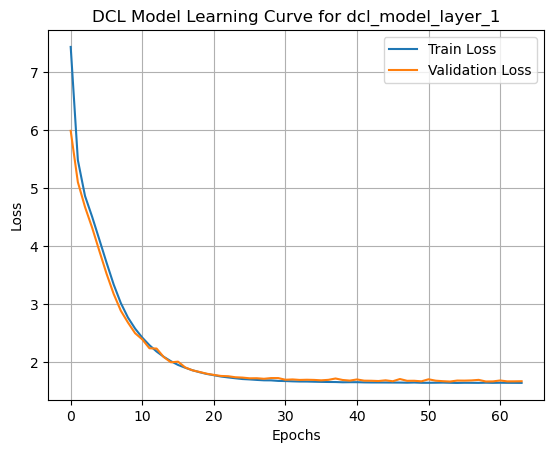

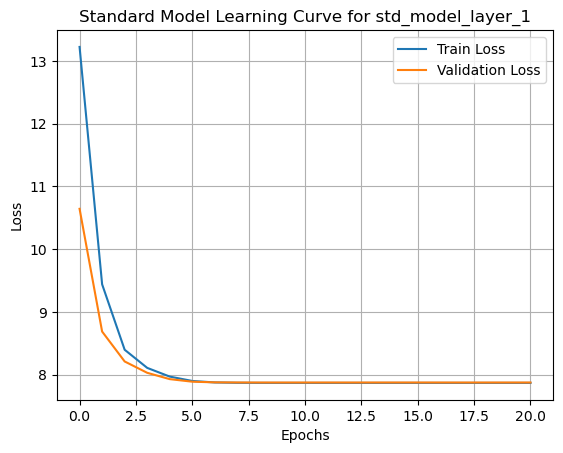

764/764 [==============================] - 2s 2ms/step
dcl_model_layer_1 Bond Accuracy: 0.9751 ± 0.0583
std_model_layer_1 Bond Accuracy: 0.0777 ± 0.1523
dcl_model_layer_1 Unbond Accuracy: 0.9709 ± 0.0121
std_model_layer_1 Unbond Accuracy: 0.0653 ± 0.0145
dcl_model_layer_1 Accuracy: 0.9468 ± 0.0596
std_model_layer_1 Accuracy: 0.0064 ± 0.0139


In [8]:
dcl_model, std_model = dcl_and_std_bond_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=1)
model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 40s 30ms/step - loss: 6.5768 - val_loss: 4.0639
Epoch 2/100
1223/1223 [==============================] - 35s 28ms/step - loss: 3.3897 - val_loss: 2.8971
Epoch 3/100
1223/1223 [==============================] - 35s 28ms/step - loss: 2.5738 - val_loss: 2.3288
Epoch 4/100
1223/1223 [==============================] - 34s 28ms/step - loss: 2.1422 - val_loss: 2.0055
Epoch 5/100
1223/1223 [==============================] - 34s 28ms/step - loss: 1.8851 - val_loss: 1.8018
Epoch 6/100
1223/1223 [==============================] - 34s 28ms/step - loss: 1.6888 - val_loss: 1.6925
Epoch 7/100
1223/1223 [==============================] - 34s 28ms/step - loss: 1.5229 - val_loss: 1.4424
Epoch 8/100
1223/1223 [==============================] - 34s 28ms/step - loss: 1.3751 - val_loss: 1.5117
Epoch 9/100
1223/1223 [==============================] - 34s 28ms/step - loss: 1.2626 - val_loss: 1.2859
Epoch 10/100
1223/1223 [==============================]

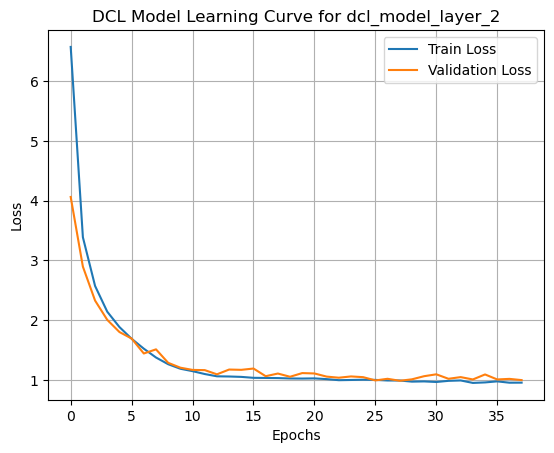

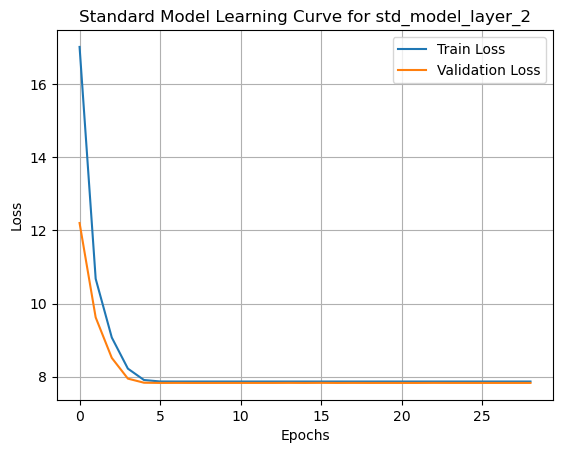

764/764 [==============================] - 2s 2ms/step
dcl_model_layer_2 Bond Accuracy: 0.9736 ± 0.0582
std_model_layer_2 Bond Accuracy: 0.0439 ± 0.0480
dcl_model_layer_2 Unbond Accuracy: 0.9659 ± 0.0144
std_model_layer_2 Unbond Accuracy: 0.0655 ± 0.0152
dcl_model_layer_2 Accuracy: 0.9405 ± 0.0593
std_model_layer_2 Accuracy: 0.0031 ± 0.0039


In [9]:
dcl_model, std_model = dcl_and_std_bond_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=2)
model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 56s 42ms/step - loss: 10.3452 - val_loss: 6.4771
Epoch 2/100
1223/1223 [==============================] - 50s 41ms/step - loss: 4.1784 - val_loss: 3.6461
Epoch 3/100
1223/1223 [==============================] - 50s 41ms/step - loss: 3.3103 - val_loss: 3.0989
Epoch 4/100
1223/1223 [==============================] - 50s 41ms/step - loss: 2.6792 - val_loss: 2.4255
Epoch 5/100
1223/1223 [==============================] - 50s 41ms/step - loss: 2.3430 - val_loss: 2.3211
Epoch 6/100
1223/1223 [==============================] - 50s 41ms/step - loss: 2.1347 - val_loss: 2.0024
Epoch 7/100
1223/1223 [==============================] - 50s 41ms/step - loss: 1.9765 - val_loss: 1.8968
Epoch 8/100
1223/1223 [==============================] - 50s 41ms/step - loss: 1.8021 - val_loss: 1.8700
Epoch 9/100
1223/1223 [==============================] - 50s 41ms/step - loss: 1.6205 - val_loss: 1.4800
Epoch 10/100
1223/1223 [==============================

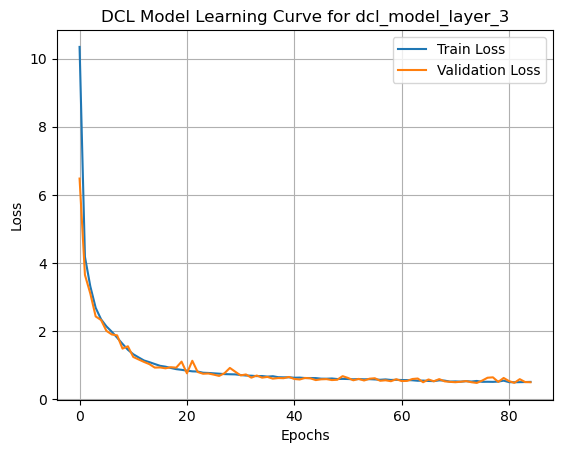

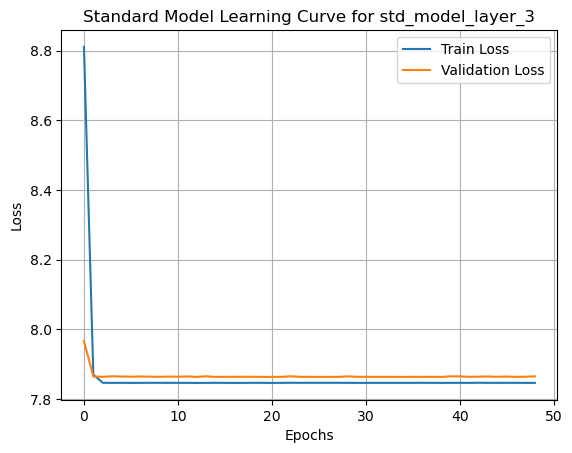

764/764 [==============================] - 2s 2ms/step
dcl_model_layer_3 Bond Accuracy: 0.9729 ± 0.0663
std_model_layer_3 Bond Accuracy: 0.0506 ± 0.0867
dcl_model_layer_3 Unbond Accuracy: 0.9642 ± 0.0163
std_model_layer_3 Unbond Accuracy: 0.0655 ± 0.0148
dcl_model_layer_3 Accuracy: 0.9385 ± 0.0699
std_model_layer_3 Accuracy: 0.0039 ± 0.0076


In [10]:
dcl_model, std_model = dcl_and_std_bond_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=3)
model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 72s 54ms/step - loss: 9.3396 - val_loss: 4.3077
Epoch 2/100
1223/1223 [==============================] - 64s 52ms/step - loss: 3.7854 - val_loss: 3.3809
Epoch 3/100
1223/1223 [==============================] - 68s 55ms/step - loss: 3.0845 - val_loss: 2.7373
Epoch 4/100
1223/1223 [==============================] - 66s 54ms/step - loss: 2.5430 - val_loss: 2.3874
Epoch 5/100
1223/1223 [==============================] - 66s 54ms/step - loss: 2.1845 - val_loss: 2.1692
Epoch 6/100
1223/1223 [==============================] - 66s 54ms/step - loss: 1.8972 - val_loss: 1.7679
Epoch 7/100
1223/1223 [==============================] - 66s 54ms/step - loss: 1.6611 - val_loss: 1.5611
Epoch 8/100
1223/1223 [==============================] - 66s 54ms/step - loss: 1.4853 - val_loss: 1.4217
Epoch 9/100
1223/1223 [==============================] - 66s 54ms/step - loss: 1.3475 - val_loss: 1.2781
Epoch 10/100
1223/1223 [==============================]

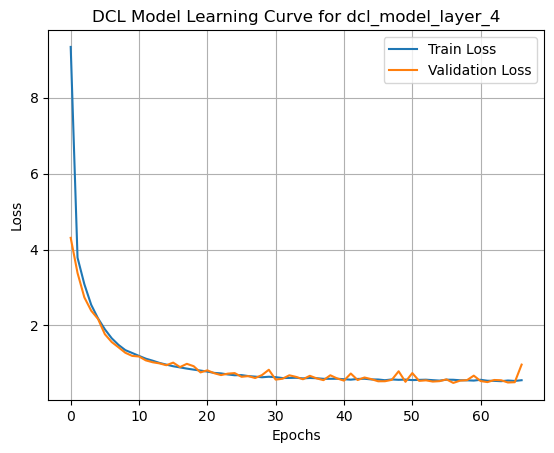

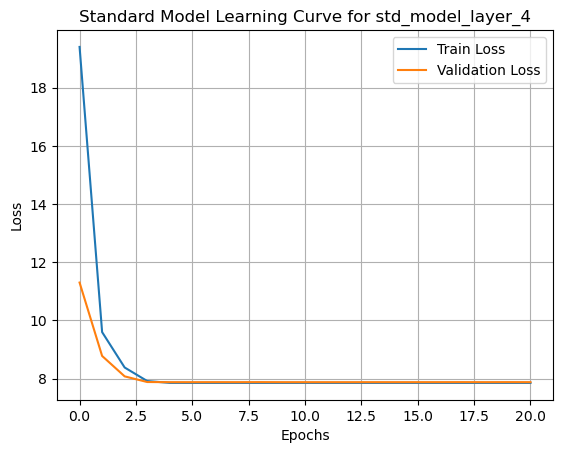

764/764 [==============================] - 2s 3ms/step
dcl_model_layer_4 Bond Accuracy: 0.9714 ± 0.0572
std_model_layer_4 Bond Accuracy: 0.0690 ± 0.1174
dcl_model_layer_4 Unbond Accuracy: 0.9646 ± 0.0156
std_model_layer_4 Unbond Accuracy: 0.0655 ± 0.0146
dcl_model_layer_4 Accuracy: 0.9374 ± 0.0616
std_model_layer_4 Accuracy: 0.0055 ± 0.0105


In [11]:
dcl_model, std_model = dcl_and_std_bond_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=4)
model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 89s 67ms/step - loss: 6.9653 - val_loss: 2.8296
Epoch 2/100
1223/1223 [==============================] - 81s 66ms/step - loss: 2.1585 - val_loss: 1.8293
Epoch 3/100
1223/1223 [==============================] - 80s 66ms/step - loss: 1.6303 - val_loss: 1.5086
Epoch 4/100
1223/1223 [==============================] - 80s 66ms/step - loss: 1.4189 - val_loss: 1.3418
Epoch 5/100
1223/1223 [==============================] - 81s 66ms/step - loss: 1.2803 - val_loss: 1.2059
Epoch 6/100
1223/1223 [==============================] - 81s 66ms/step - loss: 1.1796 - val_loss: 1.1170
Epoch 7/100
1223/1223 [==============================] - 81s 66ms/step - loss: 1.0944 - val_loss: 1.0388
Epoch 8/100
1223/1223 [==============================] - 81s 66ms/step - loss: 1.0178 - val_loss: 0.9771
Epoch 9/100
1223/1223 [==============================] - 81s 66ms/step - loss: 0.9555 - val_loss: 0.9590
Epoch 10/100
1223/1223 [==============================]

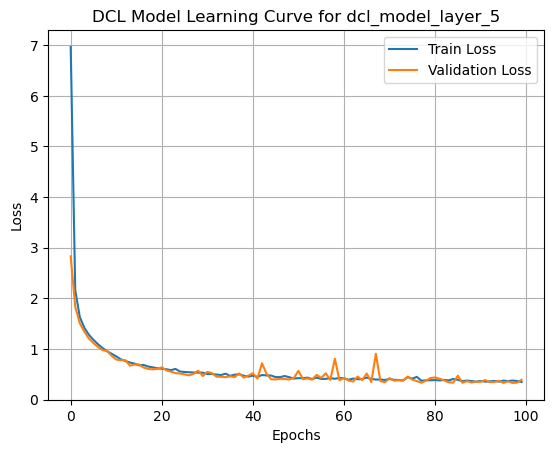

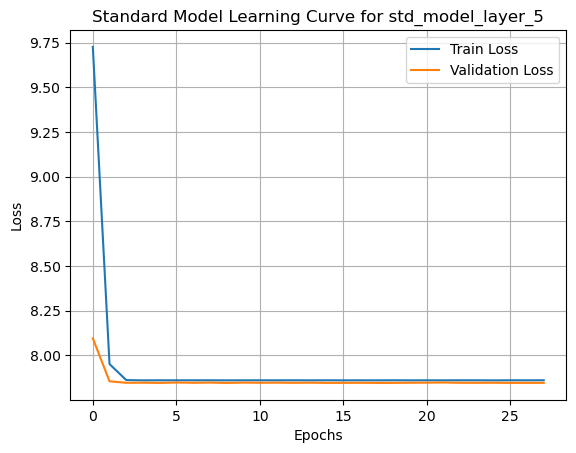

764/764 [==============================] - 2s 3ms/step
dcl_model_layer_5 Bond Accuracy: 0.9749 ± 0.0618
std_model_layer_5 Bond Accuracy: 0.5929 ± 0.1059
dcl_model_layer_5 Unbond Accuracy: 0.9657 ± 0.0139
std_model_layer_5 Unbond Accuracy: 0.0654 ± 0.0147
dcl_model_layer_5 Accuracy: 0.9417 ± 0.0641
std_model_layer_5 Accuracy: 0.0379 ± 0.0074


In [12]:
dcl_model, std_model = dcl_and_std_bond_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=5)
model_evaluation(dcl_model, std_model, atoms, distance, bonds, batch_size=64)

# Test result
The test results for the model using DCL (Dynamic Connection Layer) for molecular chemical bond prediction, as a function of the number of DCL layers, are presented as follows:

| Number of DCL Layers | Chemical Bond Prediction Accuracy | No-Connection Prediction Accuracy | Overall Accuracy |
| ------ | ------ | ------ | ------ |
| 1 | 0.9758 ± 0.0561 | 0.9647 ± 0.0145 | 0.9415 ± 0.0577 |
| 2 | 0.9302 ± 0.0998 | 0.9614 ± 0.0347 | 0.8953 ± 0.1085 |
| 3 | 0.9531 ± 0.0798 | 0.9601 ± 0.0245 | 0.9156 ± 0.0848 |
| 4 | 0.9629 ± 0.0712 | 0.9703 ± 0.0120 | 0.9347 ± 0.0738 |
| 5 | 0.9845 ± 0.0433 | 0.9658 ± 0.0139 | 0.9510 ± 0.0469 |

Chemical Bond Prediction Accuracy describes the model's ability to correctly predict the existence of chemical bonds, while No-Connection Prediction Accuracy represents the model's capability to accurately identify areas without chemical bonds. Overall Accuracy is the product of these two metrics.

In comparison, the accuracy performance of a standard model utilizing a static connection matrix is as follows:

| Standard Model Depth | Chemical Bond Prediction Accuracy | No-Connection Prediction Accuracy | Overall Accuracy |
| ------ | ------ | ------ | ------ |
| 1 | 0.1799 ± 0.0958 | 0.0654 ± 0.0145 | 0.0121 ± 0.0081 |
| 2 | 0.0762 ± 0.1521 | 0.0653 ± 0.0142 | 0.0062 ± 0.0138|
| 3 | 0.5279 ± 0.1394 | 0.0653 ± 0.0142 | 0.0346 ± 0.0139 |
| 4 | 0.0733 ± 0.1409 | 0.0654 ± 0.0146 | 0.0059 ± 0.0125|
| 5 | 0.1594 ± 0.0904| 0.0654 ± 0.0143 | 0.0108 ± 0.0078 |

While both models utilize a fully connected layer as the decoding mechanism, the DCL model can dynamically adjust the original molecular connection matrix according to the task, enabling more precise decoding and thereby achieving higher prediction accuracy.
A longitudinal comparison of the training curves of different DCL models reveals that with an increase in model layers, there is a gradual decrease in the lowest loss on both training and validation datasets. Moreover, the rate of loss reduction accelerates. This phenomenon indicates that deeper DCL stacking allows the model to converge faster and more effectively. On the other hand, the loss performance on the validation set exhibits increasing fluctuations with the depth of the model, while the loss on the training set continues to show a steady decline. This situation suggests the occurrence of overfitting in the current training data. However, the DCL layer modifies the input molecular connection matrix by altering the distribution and generating random samples, rather than direct computation. This process of random sampling somewhat mitigates the trend towards overfitting.




# Chemical Molecule Energy Prediction Test

Another important function of the DCL layer is the update of input molecule features. Since the feature update in DCL occurs after the update of the molecule's internal connection matrix, we have established a simple molecule energy prediction model and compared it with the same model constructed using standard GCN layers to test the stability of the DCL layer in updating atom features.

# Model Architecture

Molecule energy, $E_{molecule}$, can be regarded as the sum of the energies of each atom inside the molecule, $E_i$, which can be expressed as: $$ E_{molecule} = \sum_{i=1}^N(E_i) $$. The energy of each atom, $E_i$, can be considered as a function of the atom feature vector, $F_i$, expressed as: $$ E_i = f(F_i)$$. Based on these two basic assumptions, we used the DCL layer to construct a simple model to predict molecule energy. This model includes a non-trainable embedding layer to initialize the atom feature vectors and a fully connected layer to complete the transformation from atom features to atom energies. The update of atom features in this model relies entirely on the feature update function of the DCL layer. In the control model, the DCL layer for updating atom features was replaced with a standard GCN layer. The structure of the task model is shown in the figure below.


In [2]:
import tensorflow as tf
class GraphConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, 
                 activation=None,
                 use_bias=True,
                 kernel_initializer="glorot_uniform",
                 bias_initializer="zeros",
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(GraphConvolutionLayer, self).__init__(**kwargs)
        self.activation = activation
        self.use_bias=use_bias
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_initializer = bias_initializer
        self.bias_regularizer = bias_regularizer
        self.bias_constraint = bias_constraint
        
        self.supports_masking = True
        
    
    def normalize_adjacency(self, adjacency):
        degree = tf.reduce_sum(adjacency, axis=-1)
        degree += 1.0
        degree = tf.pow(degree, -0.5)
        degree = tf.linalg.diag(degree)
        return tf.matmul(degree, tf.matmul(adjacency, degree))
    
    
    def build(self, input_shapes):
        feature_shape, _ = input_shapes
        
        self.feature_transform = tf.keras.layers.Dense(units=feature_shape[-1],
                                            activation=self.activation,
                                            use_bias=self.use_bias,
                                            kernel_initializer=self.kernel_initializer,
                                            kernel_regularizer=self.kernel_regularizer,
                                            kernel_constraint=self.kernel_constraint,
                                            bias_initializer=self.bias_initializer,
                                            bias_regularizer=self.bias_regularizer,
                                            bias_constraint=self.bias_constraint)
        super().build(input_shapes)
                 
    def call(self, inputs, mask=None):
        node_feature, adjacency_matrix = inputs
        if mask is not None:
            if isinstance(mask, tuple) and len(mask) == 2:
                self._node_mask, self._adjacency_mask = mask
                self._node_mask = tf.cast(self._node_mask, dtype=tf.float32)
                self._adjacency_mask = tf.cast(self._adjacency_mask, dtype=tf.float32)
                if tf.rank(self._node_mask) < tf.rank(node_feature):
                    self._node_mask = self._node_mask[...,tf.newaxis]
                if tf.rank(self._adjacency_mask) < tf.rank(adjacency_matrix):
                    self._adjacency_mask = self._adjacency_mask[...,tf.newaxis]
                adjacency_matrix = adjacency_matrix * self._adjacency_mask
                node_feature = node_feature * self._node_mask
                
            else:
                self._node_mask = tf.cast(mask, dtype=tf.float32)
                if tf.rank(self._node_mask) != 1: 
                    self._adjacency_mask = tf.einsum("...i,...j->...ij", self._node_mask, self._node_mask)
                else:
                    self._adjacency_mask = tf.einsum("i,j->ij", self._node_mask, self._node_mask)
                
                if tf.rank(self._adjacency_mask) < tf.rank(adjacency_matrix):
                    self._adjacency_mask = self._adjacency_mask[...,tf.newaxis]
                
                if tf.rank(self._node_mask) < tf.rank(node_feature):
                    self._node_mask = self._node_mask[...,tf.newaxis]
                adjacency_matrix = adjacency_matrix * self._adjacency_mask
                
                node_feature = node_feature * self._node_mask
        adjacency_matrix = self.normalize_adjacency(adjacency=adjacency_matrix)

        
        fusion_feature = tf.matmul(adjacency_matrix, node_feature)
        fusion_feature = self.feature_transform(fusion_feature)

        if mask is not None:
            fusion_feature *= self._node_mask
        return fusion_feature
    
    def compute_mask(self, inputs, mask=None):
        if mask is not None:
            return self._node_mask
        return None
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
    def get_config(self):
        base_config = super().get_config()
        config = self.feature_transform.get_config()
        return {**base_config, **config}

In [3]:
import tensorflow as tf

class GCNEnergyModel(tf.keras.Model):
    def __init__(self, atom_types, feature_dim, layers=1, **kwargs):
        super(GCNEnergyModel, self).__init__(**kwargs)
        self._embedding = tf.keras.layers.Embedding(atom_types+1, feature_dim, name='atomic_embedding', trainable=False)
        self._gcn_block = [GraphConvolutionLayer(activation='sigmoid', name=f"gcn_block_{i}") for i in range(layers)]
        self._dense = tf.keras.layers.Dense(1, name='energy_dense_block')

    def call(self, atomic_tensor, distance_tensor):
        atomic_feature_tensor = self._embedding(atomic_tensor)
        for gcn in self._gcn_block:
            atomic_feature_tensor = gcn([atomic_feature_tensor, distance_tensor])
        energy_tensor = self._dense(atomic_feature_tensor)
        return tf.reduce_sum(energy_tensor, axis=[1,2])
    

class DCLEnergyModel(tf.keras.Model):
    def __init__(self, atom_types, feature_dim, num_heads, depth, temperature, layers=1, **kwargs):
        super(DCLEnergyModel, self).__init__(**kwargs)
        self._embedding = tf.keras.layers.Embedding(atom_types+1, feature_dim, name='atomic_embedding', trainable=False)
        self._dcl_block = [DynamicConnectionLayer(num_heads, depth, temperature, name=f"dcl_block_{i}") for i in range(layers)]
        self._dense = tf.keras.layers.Dense(1, name='energy_dense_block')

    def call(self, atomic_tensor, distance_tensor):
        atomic_feature_tensor = self._embedding(atomic_tensor)
        for dcl in self._dcl_block:
            atomic_feature_tensor, distance_tensor = dcl(atomic_feature_tensor, distance_tensor)
        energy_tensor = self._dense(atomic_feature_tensor)
        return tf.reduce_sum(energy_tensor, axis=[1,2])

In [10]:
def dcl_and_std_energy_models(atom_types, feature_dim, num_heads, depth, temperature, layers=1):
    atomic_input = tf.keras.Input(shape=(29,), name="atomic_input")
    distance_input = tf.keras.Input(shape=(29, 29), name="distance_input")

    dcl_core = DCLEnergyModel(atom_types, feature_dim, num_heads, depth, temperature, layers=layers)
    std_core = GCNEnergyModel(atom_types, feature_dim, layers=layers)

    dcl_model = tf.keras.Model(inputs=[atomic_input, distance_input], outputs=dcl_core(atomic_input, distance_input), name="dcl_energy_model_layer_{}".format(layers))
    std_model = tf.keras.Model(inputs=[atomic_input, distance_input], outputs=std_core(atomic_input, distance_input), name="std_energy_model_layer_{}".format(layers))

    return dcl_model, std_model

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def energy_model_evaluation(dcl_model, std_model, atoms, distance, energy, layers=1, batch_size=32):
    dcl_name = dcl_model.name
    std_name = std_model.name
    train_atoms, test_atoms, train_distance, test_distance, train_energy, test_energy = train_test_split(atoms, distance, energy, test_size=0.2)

    dcl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
    std_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

    dcl_history = dcl_model.fit([train_atoms, train_distance], train_energy, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{dcl_name}.csv"),
                                           tf.keras.callbacks.ModelCheckpoint(f"{dcl_name}.h5", save_best_only=True, save_weights_only=True),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{dcl_name}.csv"),
                                        #    tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/test/{dcl_name}.h5", save_best_only=True, save_weights_only=True)
                                        ])

    std_history = std_model.fit([train_atoms, train_distance], train_energy, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{std_name}.csv"),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{std_name}.csv")
                                        ])

    def plot_learning_curve(history, title, model_name):
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{title} Learning Curve for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_learning_curve(dcl_history, 'DCL Model', dcl_name)
    plot_learning_curve(std_history, 'Standard Model', std_name)

    dcl_pred = dcl_model.predict([test_atoms, test_distance])
    std_pred = std_model.predict([test_atoms, test_distance])

    dcl_mae_loss = np.abs(test_energy - dcl_pred)
    dcl_mse_loss = np.square(test_energy - dcl_pred)
    std_mae_loss = np.abs(test_energy - std_pred)
    std_mse_loss = np.square(test_energy - std_pred)


    dcl_mae_mean = np.mean(dcl_mae_loss)
    dcl_mae_std = np.std(dcl_mae_loss)
    dcl_mse_mean = np.mean(dcl_mse_loss)
    dcl_mse_std = np.std(dcl_mse_loss)

    std_mae_mean = np.mean(std_mae_loss)
    std_mae_std = np.std(std_mae_loss)
    std_mse_mean = np.mean(std_mse_loss)
    std_mse_std = np.std(std_mse_loss)

    print(f"{dcl_name} MAE: {dcl_mae_mean:.4f} ± {dcl_mae_std:.4f}")
    print(f"{std_name} MAE: {std_mae_mean:.4f} ± {std_mae_std:.4f}")
    print(f"{dcl_name} MSE: {dcl_mse_mean:.4f} ± {dcl_mse_std:.4f}")
    print(f"{std_name} MSE: {std_mse_mean:.4f} ± {std_mse_std:.4f}")



In [17]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File(
    'energy_ready_data.pbz2',
    # '/content/drive/MyDrive/test/energy_ready_data.pbz2',
     'rb') as f:
    data = pickle.load(f)

atoms = np.array(data['Pad Atoms'].to_list())
distance = np.array(data['Pad Distance'].to_list())
energy = np.array(data['G Energy'].to_list())

Epoch 1/100
1339/1339 [==============================] - 18s 12ms/step - loss: 131217.3906 - val_loss: 108203.2578
Epoch 2/100
1339/1339 [==============================] - 16s 12ms/step - loss: 89211.3984 - val_loss: 71724.1875
Epoch 3/100
1339/1339 [==============================] - 16s 12ms/step - loss: 57465.8242 - val_loss: 44488.9805
Epoch 4/100
1339/1339 [==============================] - 16s 12ms/step - loss: 34184.0703 - val_loss: 24997.0703
Epoch 5/100
1339/1339 [==============================] - 16s 12ms/step - loss: 18101.7051 - val_loss: 12202.8721
Epoch 6/100
1339/1339 [==============================] - 16s 12ms/step - loss: 8226.5527 - val_loss: 5092.0181
Epoch 7/100
1339/1339 [==============================] - 16s 12ms/step - loss: 3372.5598 - val_loss: 2235.0957
Epoch 8/100
1339/1339 [==============================] - 16s 12ms/step - loss: 1812.7085 - val_loss: 1541.1189
Epoch 9/100
1339/1339 [==============================] - 16s 12ms/step - loss: 1207.3350 - val_loss:

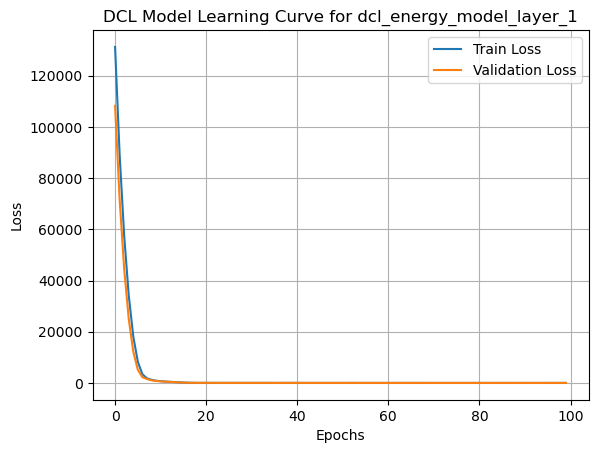

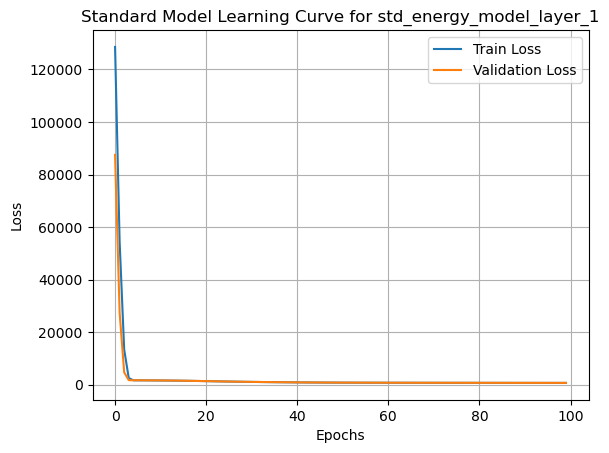

837/837 [==============================] - 1s 2ms/step
dcl_energy_model_layer_1 MAE: 0.8588 ± 1.0989
std_energy_model_layer_1 MAE: 15.1259 ± 20.0211
dcl_energy_model_layer_1 MSE: 1.9453 ± 47.6452
std_energy_model_layer_1 MSE: 629.6390 ± 2515.9483


In [18]:
dcl_energy_model, std_energy_model = dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=1)
energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, distance, energy, layers=1, batch_size=64)

Epoch 1/100
1339/1339 [==============================] - 36s 24ms/step - loss: 132498.1406 - val_loss: 114173.0703
Epoch 2/100
1339/1339 [==============================] - 32s 24ms/step - loss: 98004.7891 - val_loss: 83416.6328
Epoch 3/100
1339/1339 [==============================] - 32s 24ms/step - loss: 70291.5469 - val_loss: 58547.8477
Epoch 4/100
1339/1339 [==============================] - 33s 24ms/step - loss: 48084.5039 - val_loss: 38842.6328
Epoch 5/100
1339/1339 [==============================] - 32s 24ms/step - loss: 30795.5527 - val_loss: 23841.7090
Epoch 6/100
1339/1339 [==============================] - 32s 24ms/step - loss: 18025.0898 - val_loss: 13184.3467
Epoch 7/100
1339/1339 [==============================] - 32s 24ms/step - loss: 9400.7568 - val_loss: 6449.9502
Epoch 8/100
1339/1339 [==============================] - 32s 24ms/step - loss: 4399.3960 - val_loss: 2999.1899
Epoch 9/100
1339/1339 [==============================] - 32s 24ms/step - loss: 2207.7297 - val_los

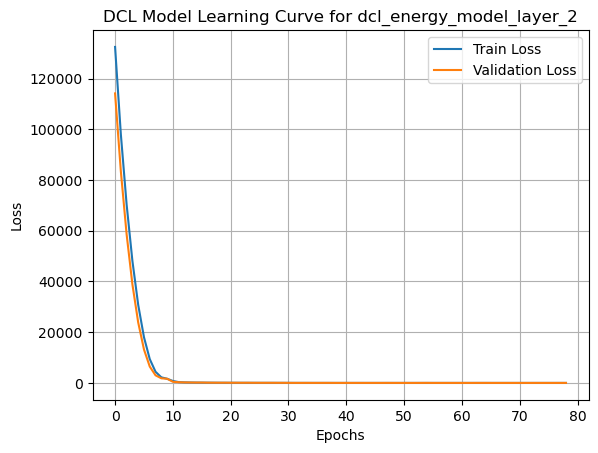

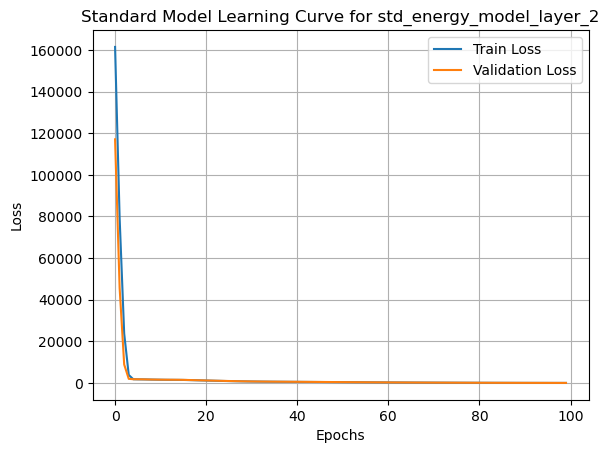

837/837 [==============================] - 2s 2ms/step
dcl_energy_model_layer_2 MAE: 0.4917 ± 0.9353
std_energy_model_layer_2 MAE: 4.8135 ± 4.5647
dcl_energy_model_layer_2 MSE: 1.1166 ± 18.2156
std_energy_model_layer_2 MSE: 44.0057 ± 187.3261


In [19]:
dcl_energy_model, std_energy_model = dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=2)
energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, distance, energy, layers=1, batch_size=64)

Epoch 1/100
1339/1339 [==============================] - 52s 35ms/step - loss: 121357.0625 - val_loss: 102176.4062
Epoch 2/100
1339/1339 [==============================] - 48s 36ms/step - loss: 86325.7031 - val_loss: 71196.0625
Epoch 3/100
1339/1339 [==============================] - 48s 36ms/step - loss: 58759.4766 - val_loss: 46975.2422
Epoch 4/100
1339/1339 [==============================] - 48s 36ms/step - loss: 37497.7812 - val_loss: 28665.0625
Epoch 5/100
1339/1339 [==============================] - 48s 36ms/step - loss: 21855.3281 - val_loss: 15697.5068
Epoch 6/100
1339/1339 [==============================] - 48s 36ms/step - loss: 11285.6465 - val_loss: 7502.1333
Epoch 7/100
1339/1339 [==============================] - 48s 36ms/step - loss: 5116.7778 - val_loss: 3279.9854
Epoch 8/100
1339/1339 [==============================] - 48s 36ms/step - loss: 2376.6987 - val_loss: 1844.3463
Epoch 9/100
1339/1339 [==============================] - 48s 36ms/step - loss: 1661.4247 - val_loss

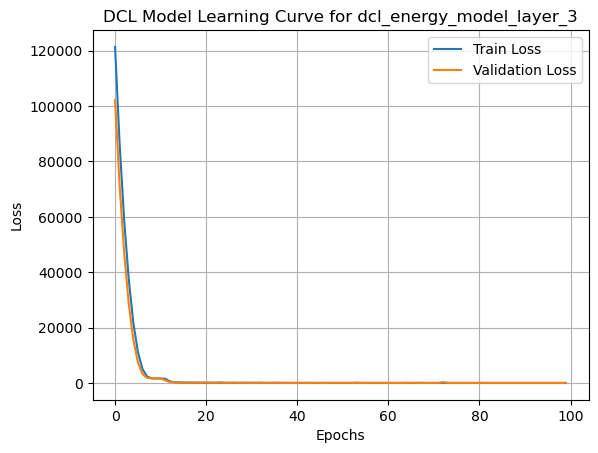

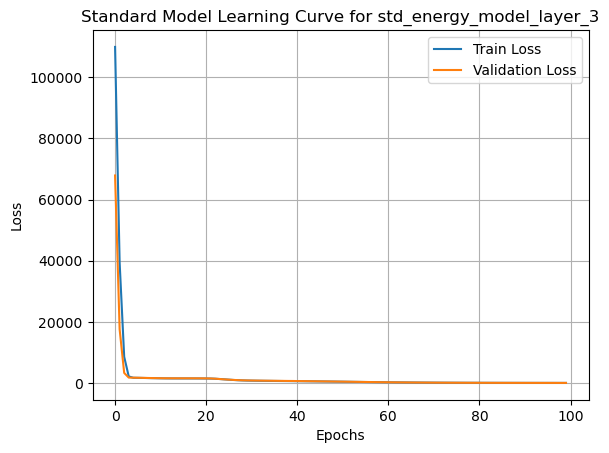

837/837 [==============================] - 2s 2ms/step
dcl_energy_model_layer_3 MAE: 0.6507 ± 1.0363
std_energy_model_layer_3 MAE: 5.2655 ± 5.6246
dcl_energy_model_layer_3 MSE: 1.4973 ± 98.1034
std_energy_model_layer_3 MSE: 59.3611 ± 505.0543


In [20]:
dcl_energy_model, std_energy_model = dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=3)
energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, distance, energy, layers=1, batch_size=64)

Epoch 1/100
1339/1339 [==============================] - 101s 72ms/step - loss: 129135.1172 - val_loss: 109432.4453
Epoch 2/100
1339/1339 [==============================] - 96s 72ms/step - loss: 92604.0938 - val_loss: 77195.2344
Epoch 3/100
1339/1339 [==============================] - 120s 90ms/step - loss: 63847.5156 - val_loss: 51721.6992
Epoch 4/100
1339/1339 [==============================] - 124s 92ms/step - loss: 41426.9180 - val_loss: 32218.8145
Epoch 5/100
1339/1339 [==============================] - 123s 92ms/step - loss: 24687.6250 - val_loss: 18132.5312
Epoch 6/100
1339/1339 [==============================] - 123s 92ms/step - loss: 13112.9639 - val_loss: 8944.8447
Epoch 7/100
1339/1339 [==============================] - 124s 92ms/step - loss: 6096.7202 - val_loss: 3929.3374
Epoch 8/100
1339/1339 [==============================] - 123s 92ms/step - loss: 2745.8186 - val_loss: 2000.4813
Epoch 9/100
1339/1339 [==============================] - 123s 92ms/step - loss: 1737.8638 - 

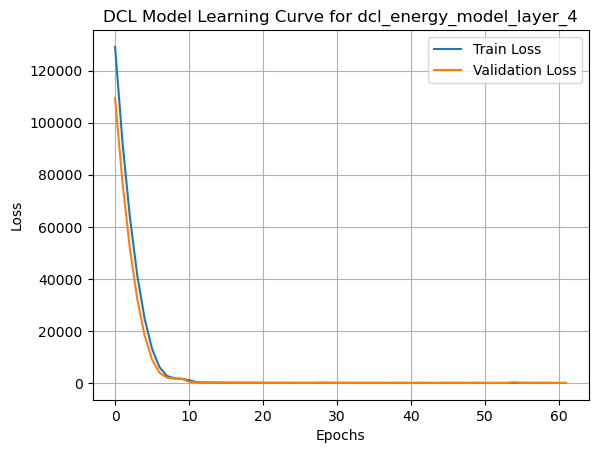

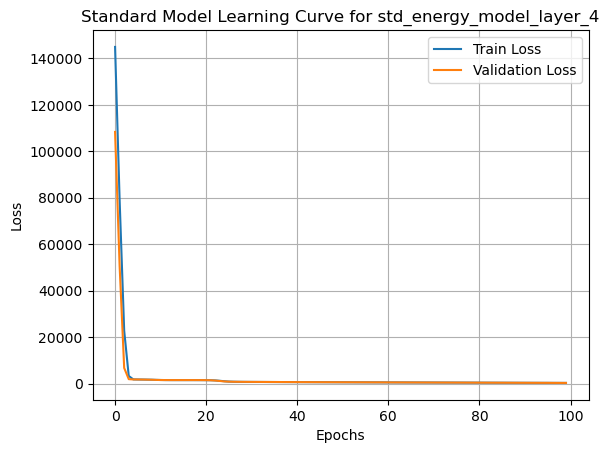

837/837 [==============================] - 3s 3ms/step
dcl_energy_model_layer_4 MAE: 1.6517 ± 1.8374
std_energy_model_layer_4 MAE: 10.5366 ± 14.2337
dcl_energy_model_layer_4 MSE: 6.1045 ± 32.4672
std_energy_model_layer_4 MSE: 313.6195 ± 1451.5859


In [21]:
dcl_energy_model, std_energy_model = dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=4)
energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, distance, energy, layers=1, batch_size=64)

Epoch 1/100
1339/1339 [==============================] - 152s 109ms/step - loss: 134813.1719 - val_loss: 114201.3203
Epoch 2/100
1339/1339 [==============================] - 140s 105ms/step - loss: 97027.0859 - val_loss: 80757.0234
Epoch 3/100
1339/1339 [==============================] - 140s 105ms/step - loss: 67268.5078 - val_loss: 54486.1367
Epoch 4/100
1339/1339 [==============================] - 140s 105ms/step - loss: 44068.7656 - val_loss: 34285.6875
Epoch 5/100
1339/1339 [==============================] - 140s 105ms/step - loss: 26622.0098 - val_loss: 19560.2656
Epoch 6/100
1339/1339 [==============================] - 140s 105ms/step - loss: 14391.5215 - val_loss: 9782.7236
Epoch 7/100
1339/1339 [==============================] - 140s 105ms/step - loss: 6801.7983 - val_loss: 4290.8154
Epoch 8/100
1339/1339 [==============================] - 140s 105ms/step - loss: 3027.1990 - val_loss: 2055.4082
Epoch 9/100
1339/1339 [==============================] - 140s 105ms/step - loss: 17

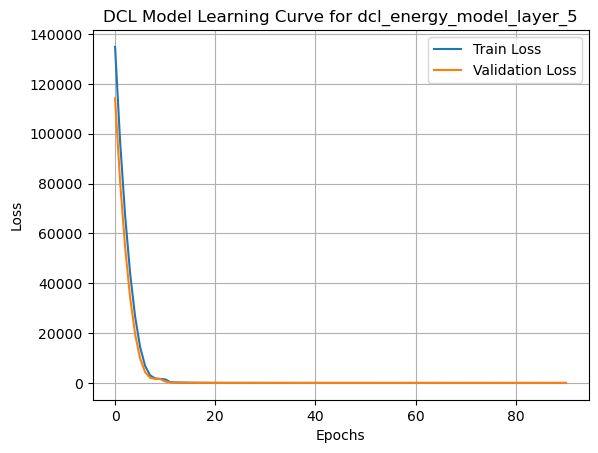

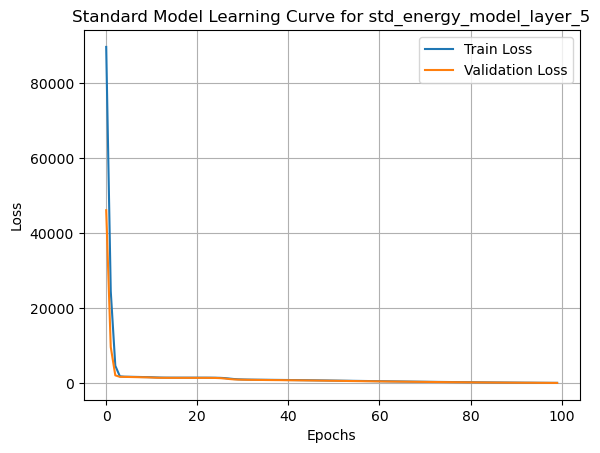

837/837 [==============================] - 3s 4ms/step
dcl_energy_model_layer_5 MAE: 0.3588 ± 0.7522
std_energy_model_layer_5 MAE: 7.0037 ± 9.3480
dcl_energy_model_layer_5 MSE: 0.6946 ± 51.1355
std_energy_model_layer_5 MSE: 136.4374 ± 677.5841


In [22]:
dcl_energy_model, std_energy_model = dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=5)
energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, distance, energy, layers=1, batch_size=64)

In [4]:
import bz2
import pickle
import numpy as np

with bz2.BZ2File(
    'energy_ready_data_2.pbz2',
    # '/content/drive/MyDrive/test/energy_ready_data_2.pbz2',
     'rb') as f:
    data = pickle.load(f)

atoms = np.array(data['Pad Atoms'].to_list())
bonds = np.array(data['Pad Bond'].to_list())
energy = np.array(data['Gibbs Energy'].to_list())

In [5]:
def bond_dcl_and_std_energy_models(atom_types, feature_dim, num_heads, depth, temperature, layers=1):
    atomic_input = tf.keras.Input(shape=(29,), name="atomic_input")
    distance_input = tf.keras.Input(shape=(29, 29), name="distance_input")

    dcl_core = DCLEnergyModel(atom_types, feature_dim, num_heads, depth, temperature, layers=layers)
    std_core = GCNEnergyModel(atom_types, feature_dim, layers=layers)

    dcl_model = tf.keras.Model(inputs=[atomic_input, distance_input], outputs=dcl_core(atomic_input, distance_input), name="dcl_energy_model_layer_bond{}".format(layers))
    std_model = tf.keras.Model(inputs=[atomic_input, distance_input], outputs=std_core(atomic_input, distance_input), name="std_energy_model_layer_bond{}".format(layers))

    return dcl_model, std_model

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def bond_energy_model_evaluation(dcl_model, std_model, atoms, bond, energy, layers=1, batch_size=32):
    dcl_name = dcl_model.name
    std_name = std_model.name
    train_atoms, test_atoms, train_distance, test_distance, train_energy, test_energy = train_test_split(atoms, bond, energy, test_size=0.2)

    dcl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
    std_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

    dcl_history = dcl_model.fit([train_atoms, train_distance], train_energy, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{dcl_name}.csv"),
                                           tf.keras.callbacks.ModelCheckpoint(f"{dcl_name}.h5", save_best_only=True, save_weights_only=True),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{dcl_name}.csv"),
                                        #    tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/test/{dcl_name}.h5", save_best_only=True, save_weights_only=True)
                                        ])

    std_history = std_model.fit([train_atoms, train_distance], train_energy, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=1,
                                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                                           tf.keras.callbacks.CSVLogger(f"{std_name}.csv"),
                                        #    tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/test/{std_name}.csv")
                                        ])

    def plot_learning_curve(history, title, model_name):
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{title} Learning Curve for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    plot_learning_curve(dcl_history, 'DCL Model', dcl_name)
    plot_learning_curve(std_history, 'Standard Model', std_name)

    dcl_pred = dcl_model.predict([test_atoms, test_distance])
    std_pred = std_model.predict([test_atoms, test_distance])

    dcl_mae_loss = np.abs(test_energy - dcl_pred)
    dcl_mse_loss = np.square(test_energy - dcl_pred)
    std_mae_loss = np.abs(test_energy - std_pred)
    std_mse_loss = np.square(test_energy - std_pred)


    dcl_mae_mean = np.mean(dcl_mae_loss)
    dcl_mae_std = np.std(dcl_mae_loss)
    dcl_mse_mean = np.mean(dcl_mse_loss)
    dcl_mse_std = np.std(dcl_mse_loss)

    std_mae_mean = np.mean(std_mae_loss)
    std_mae_std = np.std(std_mae_loss)
    std_mse_mean = np.mean(std_mse_loss)
    std_mse_std = np.std(std_mse_loss)

    print(f"{dcl_name} MAE: {dcl_mae_mean:.4f} ± {dcl_mae_std:.4f}")
    print(f"{std_name} MAE: {std_mae_mean:.4f} ± {std_mae_std:.4f}")
    print(f"{dcl_name} MSE: {dcl_mse_mean:.4f} ± {dcl_mse_std:.4f}")
    print(f"{std_name} MSE: {std_mse_mean:.4f} ± {std_mse_std:.4f}")



Epoch 1/100
1223/1223 [==============================] - 18s 13ms/step - loss: 134963.9219 - val_loss: 113359.2891
Epoch 2/100
1223/1223 [==============================] - 16s 13ms/step - loss: 96842.9141 - val_loss: 80724.4141
Epoch 3/100
1223/1223 [==============================] - 16s 13ms/step - loss: 67580.6406 - val_loss: 54850.6055
Epoch 4/100
1223/1223 [==============================] - 16s 13ms/step - loss: 44692.4258 - val_loss: 34940.5039
Epoch 5/100
1223/1223 [==============================] - 16s 13ms/step - loss: 27435.2656 - val_loss: 20351.6426
Epoch 6/100
1223/1223 [==============================] - 16s 13ms/step - loss: 15228.1016 - val_loss: 10536.2715
Epoch 7/100
1223/1223 [==============================] - 16s 13ms/step - loss: 7487.2266 - val_loss: 4837.7656
Epoch 8/100
1223/1223 [==============================] - 16s 13ms/step - loss: 3433.7468 - val_loss: 2321.5659
Epoch 9/100
1223/1223 [==============================] - 16s 13ms/step - loss: 1945.1838 - val_los

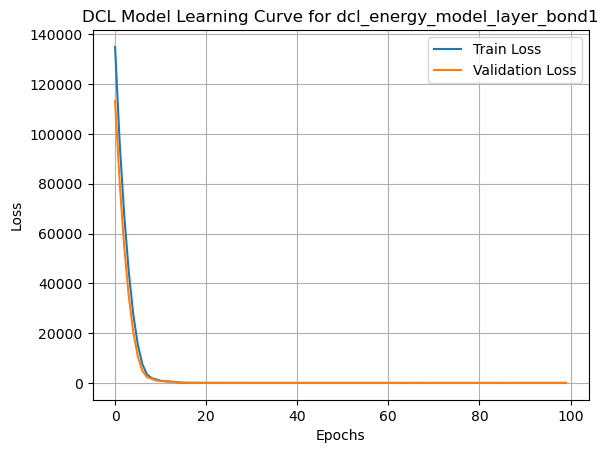

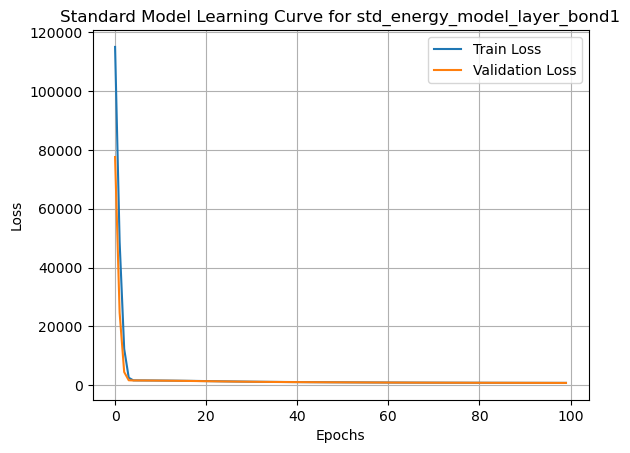

764/764 [==============================] - 2s 2ms/step
dcl_energy_model_layer_bond1 MAE: 0.4290 ± 1.5153
std_energy_model_layer_bond1 MAE: 17.3372 ± 22.2694
dcl_energy_model_layer_bond1 MSE: 2.4802 ± 171.6434
std_energy_model_layer_bond1 MSE: 796.5064 ± 3101.4203


In [7]:
dcl_energy_model, std_energy_model = bond_dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=1)
bond_energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, bonds, energy, layers=1, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 30s 22ms/step - loss: 132580.5469 - val_loss: 112947.2266
Epoch 2/100
1223/1223 [==============================] - 27s 22ms/step - loss: 95682.2188 - val_loss: 80023.4688
Epoch 3/100
1223/1223 [==============================] - 27s 22ms/step - loss: 66503.3281 - val_loss: 54291.1484
Epoch 4/100
1223/1223 [==============================] - 27s 22ms/step - loss: 43859.8789 - val_loss: 34553.6836
Epoch 5/100
1223/1223 [==============================] - 27s 22ms/step - loss: 26832.3125 - val_loss: 20103.3555
Epoch 6/100
1223/1223 [==============================] - 27s 22ms/step - loss: 14819.9971 - val_loss: 10401.8701
Epoch 7/100
1223/1223 [==============================] - 27s 22ms/step - loss: 7246.4150 - val_loss: 4794.6055
Epoch 8/100
1223/1223 [==============================] - 27s 22ms/step - loss: 3324.4172 - val_loss: 2336.1013
Epoch 9/100
1223/1223 [==============================] - 27s 22ms/step - loss: 1910.9595 - val_los

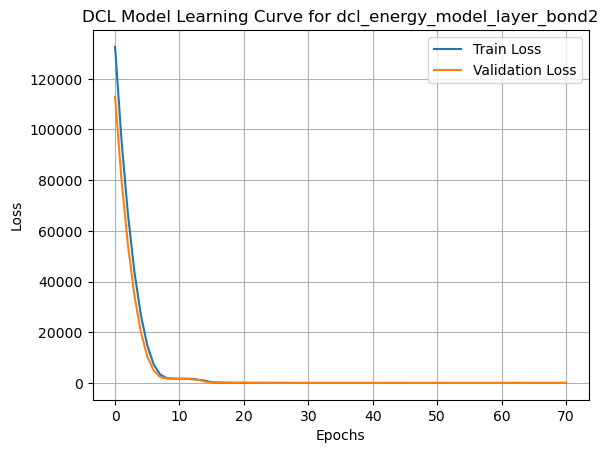

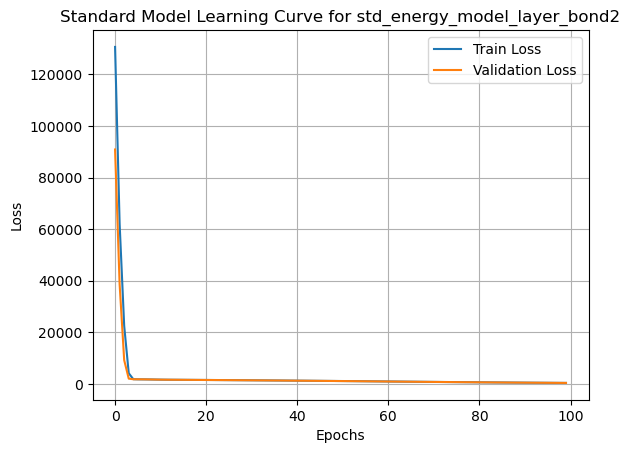

764/764 [==============================] - 2s 2ms/step
dcl_energy_model_layer_bond2 MAE: 0.4522 ± 0.7917
std_energy_model_layer_bond2 MAE: 11.9174 ± 15.5928
dcl_energy_model_layer_bond2 MSE: 0.8313 ± 47.1314
std_energy_model_layer_bond2 MSE: 385.1595 ± 1556.3322


In [8]:
dcl_energy_model, std_energy_model = bond_dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=2)
bond_energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, bonds, energy, layers=1, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 55s 41ms/step - loss: 124547.6016 - val_loss: 105563.3438
Epoch 2/100
1223/1223 [==============================] - 46s 38ms/step - loss: 89168.7109 - val_loss: 74286.3203
Epoch 3/100
1223/1223 [==============================] - 46s 38ms/step - loss: 61383.6055 - val_loss: 49777.6133
Epoch 4/100
1223/1223 [==============================] - 47s 38ms/step - loss: 39891.8125 - val_loss: 31122.7598
Epoch 5/100
1223/1223 [==============================] - 46s 38ms/step - loss: 23918.0566 - val_loss: 17682.7266
Epoch 6/100
1223/1223 [==============================] - 47s 38ms/step - loss: 12881.1914 - val_loss: 8898.1670
Epoch 7/100
1223/1223 [==============================] - 46s 38ms/step - loss: 6151.2847 - val_loss: 4039.3611
Epoch 8/100
1223/1223 [==============================] - 46s 38ms/step - loss: 2862.8386 - val_loss: 2079.1741
Epoch 9/100
1223/1223 [==============================] - 46s 38ms/step - loss: 1804.4196 - val_loss

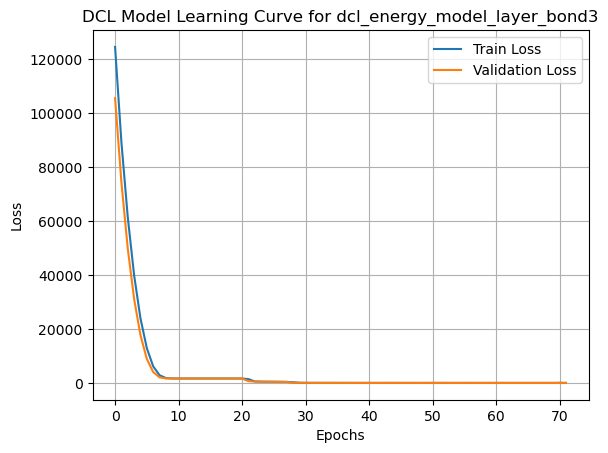

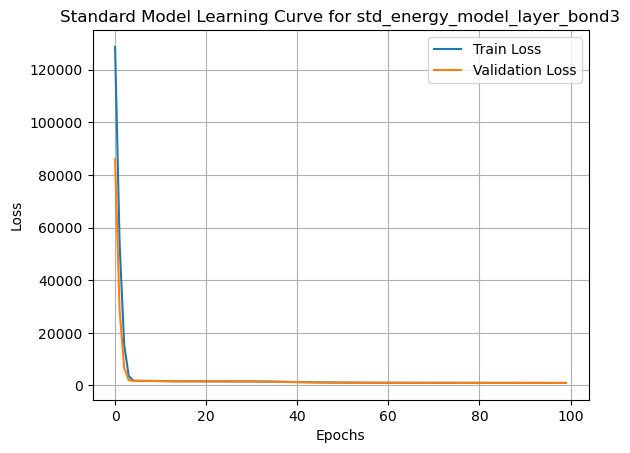

764/764 [==============================] - 2s 2ms/step
dcl_energy_model_layer_bond3 MAE: 0.5465 ± 1.0483
std_energy_model_layer_bond3 MAE: 19.8349 ± 23.7223
dcl_energy_model_layer_bond3 MSE: 1.3977 ± 73.9311
std_energy_model_layer_bond3 MSE: 956.1704 ± 3217.3527


In [9]:
dcl_energy_model, std_energy_model = bond_dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=3)
bond_energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, bonds, energy, layers=1, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 88s 67ms/step - loss: 124325.9453 - val_loss: 106760.0391
Epoch 2/100
1223/1223 [==============================] - 75s 62ms/step - loss: 91308.6250 - val_loss: 77368.2266
Epoch 3/100
1223/1223 [==============================] - 75s 62ms/step - loss: 63885.8008 - val_loss: 51729.3398
Epoch 4/100
1223/1223 [==============================] - 75s 61ms/step - loss: 41366.0312 - val_loss: 32345.9277
Epoch 5/100
1223/1223 [==============================] - 75s 62ms/step - loss: 24865.4766 - val_loss: 18487.5781
Epoch 6/100
1223/1223 [==============================] - 75s 62ms/step - loss: 13479.6895 - val_loss: 9379.3008
Epoch 7/100
1223/1223 [==============================] - 75s 61ms/step - loss: 6479.2285 - val_loss: 4274.3589
Epoch 8/100
1223/1223 [==============================] - 75s 61ms/step - loss: 2999.2856 - val_loss: 2155.2644
Epoch 9/100
1223/1223 [==============================] - 77s 63ms/step - loss: 1835.9861 - val_loss

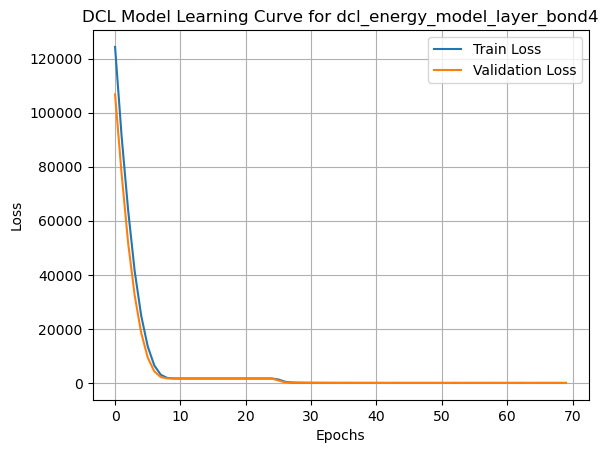

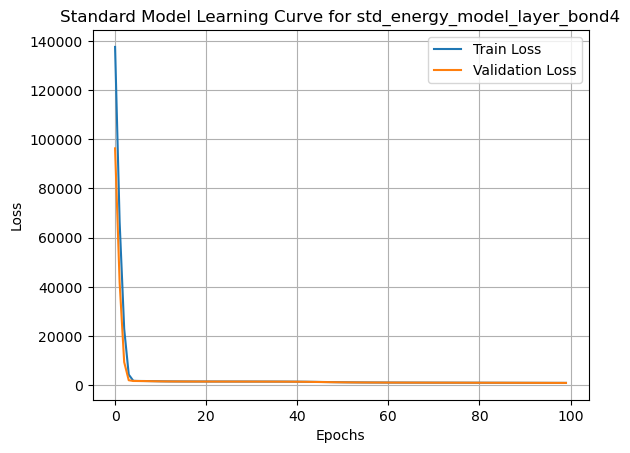

764/764 [==============================] - 2s 3ms/step
dcl_energy_model_layer_bond4 MAE: 0.4379 ± 0.6356
std_energy_model_layer_bond4 MAE: 20.2412 ± 24.5865
dcl_energy_model_layer_bond4 MSE: 0.5958 ± 7.0198
std_energy_model_layer_bond4 MSE: 1014.2023 ± 3214.9783


In [10]:
dcl_energy_model, std_energy_model = bond_dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=4)
bond_energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, bonds, energy, layers=1, batch_size=64)

Epoch 1/100
1223/1223 [==============================] - 99s 75ms/step - loss: 134224.9219 - val_loss: 114294.3359
Epoch 2/100
1223/1223 [==============================] - 90s 73ms/step - loss: 96927.7734 - val_loss: 80844.1797
Epoch 3/100
1223/1223 [==============================] - 90s 73ms/step - loss: 67389.6953 - val_loss: 54898.8984
Epoch 4/100
1223/1223 [==============================] - 89s 73ms/step - loss: 44536.5273 - val_loss: 34992.7930
Epoch 5/100
1223/1223 [==============================] - 90s 73ms/step - loss: 27330.3770 - val_loss: 20405.9785
Epoch 6/100
1223/1223 [==============================] - 90s 73ms/step - loss: 15159.7041 - val_loss: 10574.3076
Epoch 7/100
1223/1223 [==============================] - 90s 73ms/step - loss: 7450.2988 - val_loss: 4868.7456
Epoch 8/100
1223/1223 [==============================] - 90s 73ms/step - loss: 3423.6350 - val_loss: 2341.8376
Epoch 9/100
1223/1223 [==============================] - 90s 73ms/step - loss: 1951.3927 - val_los

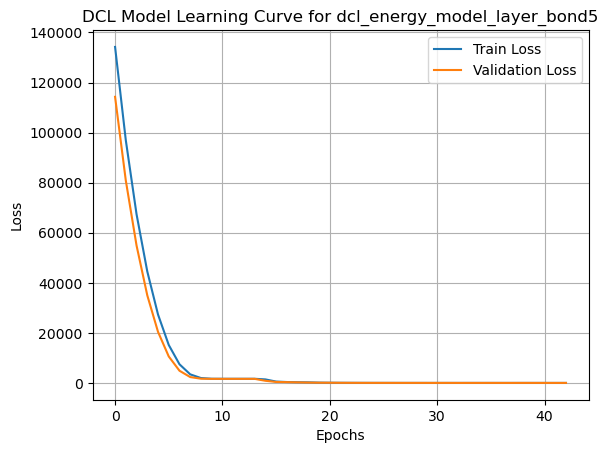

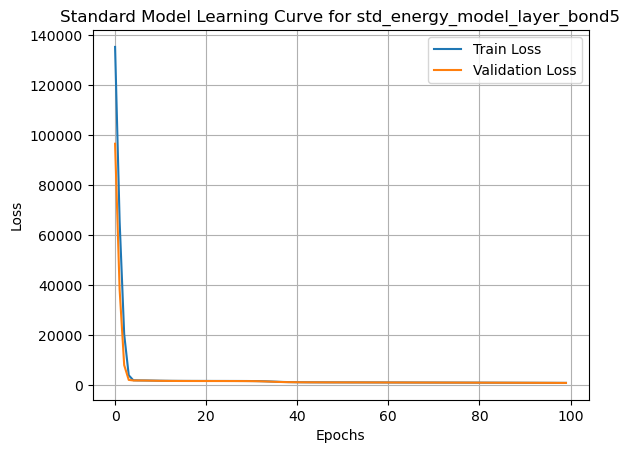

764/764 [==============================] - 3s 3ms/step
dcl_energy_model_layer_bond5 MAE: 0.5808 ± 1.3268
std_energy_model_layer_bond5 MAE: 17.2670 ± 21.5795
dcl_energy_model_layer_bond5 MSE: 2.0977 ± 72.5681
std_energy_model_layer_bond5 MSE: 763.8254 ± 2568.1152


In [11]:
dcl_energy_model, std_energy_model = bond_dcl_and_std_energy_models(atom_types=9, feature_dim=8, num_heads=5, depth=8, temperature=1.0, layers=5)
bond_energy_model_evaluation(dcl_energy_model, std_energy_model, atoms, bonds, energy, layers=1, batch_size=64)